# Street View House Numbers: Digit Recognition

## Background and Context:
The ability to process visual information using machine learning algorithms can be very useful as demonstrated in various applications. The Street View House Numbers (SVHN) dataset is one of the most popular ones. It has been used in neural networks created by Google to read house numbers and match them to their geolocations. This is a great benchmark dataset to play with, learn and train models that accurately identify street numbers, and incorporate them into all sorts of projects.

## Objective:
In this project, we will use a dataset with images centered around a single digit (many of the images do contain some distractors at the sides). Although we are taking a sample of the data which is simple, it is more complex than MNIST because of the distractors. Given the dataset, our aim is to build a model that can identify house numbers in an image.

## Dataset:
The dataset has the following features:
* Number of classes: 10
* Training data: 42000 images
* Testing data: 18000 images

In [1]:
# Course: Introduction to Neural Networks
# Project: Street View House Numbers: Digit Recognition
# Student: Sameer Girolkar
# Date: Apr 18, 2022

## Initial setup
Let's start by importing the required libraries, setting up some basic configurations for EDA.

We will also write some basic functions to help us visualize the data.

In [2]:
import h5py
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from random import shuffle
from collections import Counter
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    precision_score, 
    recall_score, 
    f1_score
)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import (
    callbacks,
    regularizers,
    backend,
    optimizers
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Dense, 
    Dropout, 
    InputLayer, 
    BatchNormalization
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import (
    ModelCheckpoint, 
    EarlyStopping,
    ReduceLROnPlateau
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
import warnings
warnings.filterwarnings("ignore")

## Functions for EDA and Visualizations

In [3]:
# function to plot histogram and barplot together
def histogram_boxplot(
    data, 
    feature, 
    figsize=(12, 7), 
    kde=False, 
    bins=None, 
    hue=None, 
    element="bars"
):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    # creating the 2 subplots
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    ) 
    # boxplot will be created and 
    # a star will indicate the mean value of the column
    sns.boxplot(
        data=data, 
        x=feature, 
        ax=ax_box2, 
        showmeans=True, 
        color="violet", 
        hue=hue
    )  
    # For histogram
    sns.histplot(
        data=data,
        x=feature,
        kde=kde,
        ax=ax_hist2,
        bins=bins,
        palette="winter",
        hue=hue,
        element=element,
    ) if bins else sns.histplot(
        data=data, 
        x=feature, 
        kde=kde, 
        ax=ax_hist2, 
        hue=hue, 
        element=element
    )  
    # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].mean(),
        color="green", 
        linestyle="--"
    )  
    ax_hist2.axvline(
        data[feature].median(), 
        color="black",
         linestyle="-"
    )

In [4]:
# function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None, hue=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    hue: Grouping variable
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 5, 5))
    else:
        plt.figure(figsize=(n + 5, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
        hue=hue,
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [5]:
# function to create box-plots by category
def box_plot_by_cat(data, category_col, y, n=None):
    """
    Boxplot by category

    data: dataframe
    category_col: column for which the boxplot will be created
    y: independent variable
    n: no of values to plot
    """
    count = data[category_col].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))
    sns.boxplot(
        x=category_col,
        y=y,
        data=data,
        order=data[category_col].value_counts().index[:n].sort_values(),
    )
    plt.xticks(rotation=90)
    plt.show()


In [6]:
# function to plot stacked bar chart
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(
        data[predictor], data[target], margins=True
    ).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 75)
    tab = pd.crosstab(
        data[predictor], data[target], normalize="index"
    ).sort_values(
        by=sorter, ascending=False
    )
    ax = tab.plot(kind="bar", stacked=True, figsize=(count + 7, 6))

    # for c in ax.containers:
    #     ax.bar_label(c, label_type="center", size=14, fmt="%.2f")

    plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title=target)
    plt.show()

In [7]:
# Removes the limit from the number of displayed columns
pd.set_option("display.max_columns", None)

# Let's set the limit of 200 rows max
pd.set_option("display.max_rows", 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)


In [8]:
# make the graphs look nicer
sns.set(color_codes=True)
sns.set_style("darkgrid")
# light palette for Pivot tables
cm = sns.light_palette("lightblue", as_cmap=True)
sns.set(
    rc={
        "figure.figsize": (15, 15),
        "axes.titlesize": "15",
        "xtick.labelsize": "20",
        "ytick.labelsize": "20",
    }
)

# actually display the graphs instead of generating only the object
%matplotlib inline

In [9]:
def reset_seed():
    backend.clear_session()
    # Fixing the seed for random number generators 
    # so that we can ensure we receive the same output everytime
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)
reset_seed()

## Overview of the Dataset
Let's now read the dataset

In [10]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# Open the file 
h5f = h5py.File('/content/drive/My Drive/AIML/SVHN_single_grey1.h5', 'r')

# Load the training, test and validation set
X_train = h5f['X_train'][:]
y_train1 = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test1 = h5f['y_test'][:]

# Close this file
h5f.close()

In [12]:
CATEGORIES = np.unique(y_train1)
CATEGORIES

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

#### Lets take a look at some sample Images and their labels

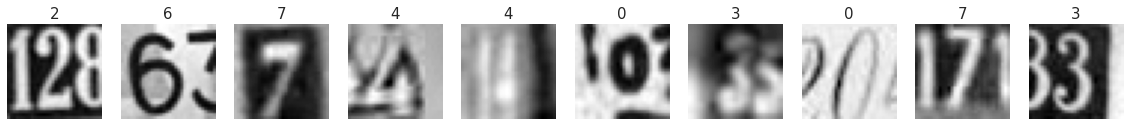

In [13]:
fig = plt.figure(figsize=(20, 2))
for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    plt.imshow(X_train[i], cmap="gray")
    plt.title(y_train1[i])
    plt.axis('off')
plt.show()

## Data Preprocessing

In [14]:
# reshaping the data at hand
X_train = X_train.reshape(X_train.shape[0], 1024)
X_test = X_test.reshape(X_test.shape[0], 1024)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (42000, 1024)
X_test shape: (18000, 1024)


In [15]:
# normalize inputs from 0-255 to 0-1; to be used with the NN
X_train = X_train / 255.0
X_test = X_test / 255.0

In [16]:
# conver to categorical
y_train = to_categorical(y_train1)
y_test = to_categorical(y_test1)

# no.of classes
num_classes = y_test.shape[1]
print(num_classes)

10


In [17]:
#create copies to preserve original data

X_train_m1 = X_train.copy()
X_test_m1 = X_test.copy()
y_train_m1 = y_train.copy()
y_test_m1 = y_test.copy()

## Model building

Lets get to building the base model

In [18]:
reset_seed()

# create model
model = Sequential()  
# Multiple Dense units with Relu activation
model.add(Dense(256, activation='relu', input_dim=1024)) 
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
# Adding the output layer 
# with 'softmax' activation for multiclass classification
model.add(Dense(num_classes, activation='softmax'))

# Compile model
model.compile(
    loss=categorical_crossentropy, 
    optimizer=Adam(lr=1e-3), 
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 10)                330       
                                                                 
Total params: 285,418
Trainable params: 285,418
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Fit the model
history = model.fit(
    X_train_m1, 
    y_train_m1, 
    validation_data=(X_test_m1, y_test_m1), 
    epochs=50, 
    batch_size=200,
)

Epoch 1/50
210/210 [==============================] - 3s 6ms/step - loss: 2.3060 - accuracy: 0.1014 - val_loss: 2.3012 - val_accuracy: 0.1104
Epoch 2/50
210/210 [==============================] - 1s 6ms/step - loss: 2.2099 - accuracy: 0.1698 - val_loss: 1.9309 - val_accuracy: 0.3077
Epoch 3/50
210/210 [==============================] - 1s 5ms/step - loss: 1.6869 - accuracy: 0.4080 - val_loss: 1.5210 - val_accuracy: 0.4747
Epoch 4/50
210/210 [==============================] - 1s 5ms/step - loss: 1.4454 - accuracy: 0.5134 - val_loss: 1.3687 - val_accuracy: 0.5401
Epoch 5/50
210/210 [==============================] - 1s 6ms/step - loss: 1.3137 - accuracy: 0.5656 - val_loss: 1.2631 - val_accuracy: 0.5868
Epoch 6/50
210/210 [==============================] - 1s 6ms/step - loss: 1.2237 - accuracy: 0.6036 - val_loss: 1.1766 - val_accuracy: 0.6274
Epoch 7/50
210/210 [==============================] - 1s 5ms/step - loss: 1.1668 - accuracy: 0.6253 - val_loss: 1.1482 - val_accuracy: 0.6296
Epoch 

In [56]:
# Final evaluation of the model
scores = model.evaluate(X_test_m1, y_test_m1, verbose=0)
print(f"Error rate in base model: {(100-scores[1]*100):.2f}%")
print(f"Accuracy of base model: {scores[1]*100:.2f}%")

Error rate in base model: 20.64%
Accuracy of base model: 79.36%


### Model Evaluation

In [21]:
def visualize_model_acc_loss_curves(history):   
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [22]:
def get_cf(y_class, pred_cl):
    cf_matrix = confusion_matrix(y_class, pred_cl)
    cf_matrix = cf_matrix/np.sum(cf_matrix, axis=1)
    return cf_matrix

def plot_confusion_matrix(
    y_train, y_test, pred_class_train, pred_class_test, class_names
):
    plt.figure(figsize=(12,20))
    cf_train = get_cf(y_train, pred_class_train)
    plt.subplot(2,1, 1)
    sns.heatmap(
        cf_train, 
        xticklabels=class_names, 
        yticklabels=class_names, 
        annot=True,
        fmt=".2f"
    )
    plt.title('Training')
    
    cf_test = get_cf(y_test, pred_class_test)
    plt.subplot(2,1, 2)
    sns.heatmap(
        cf_test, 
        xticklabels=class_names, 
        yticklabels=class_names, 
        annot=True,
        fmt=".2f"
    )
    plt.title('Testing')


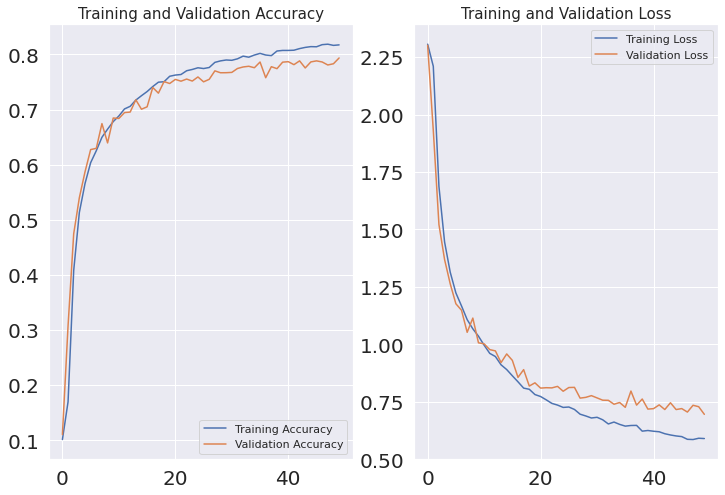

In [23]:
visualize_model_acc_loss_curves(history)

### Observations:
* Both training and validationn accuracies kept inclreassing with each epoch
* It may be helpful to use more epochs to get better performance

In [24]:
y_train_class_m1 = np.argmax(y_train_m1, axis=1)
y_test_class_m1 = np.argmax(y_test_m1, axis=1)

In [25]:
train_preds_m1 = model.predict(X_train_m1)
train_preds_m1 = np.argmax(train_preds_m1, axis=1)

test_preds_m1 = model.predict(X_test_m1)
test_preds_m1 = np.argmax(test_preds_m1, axis=1)

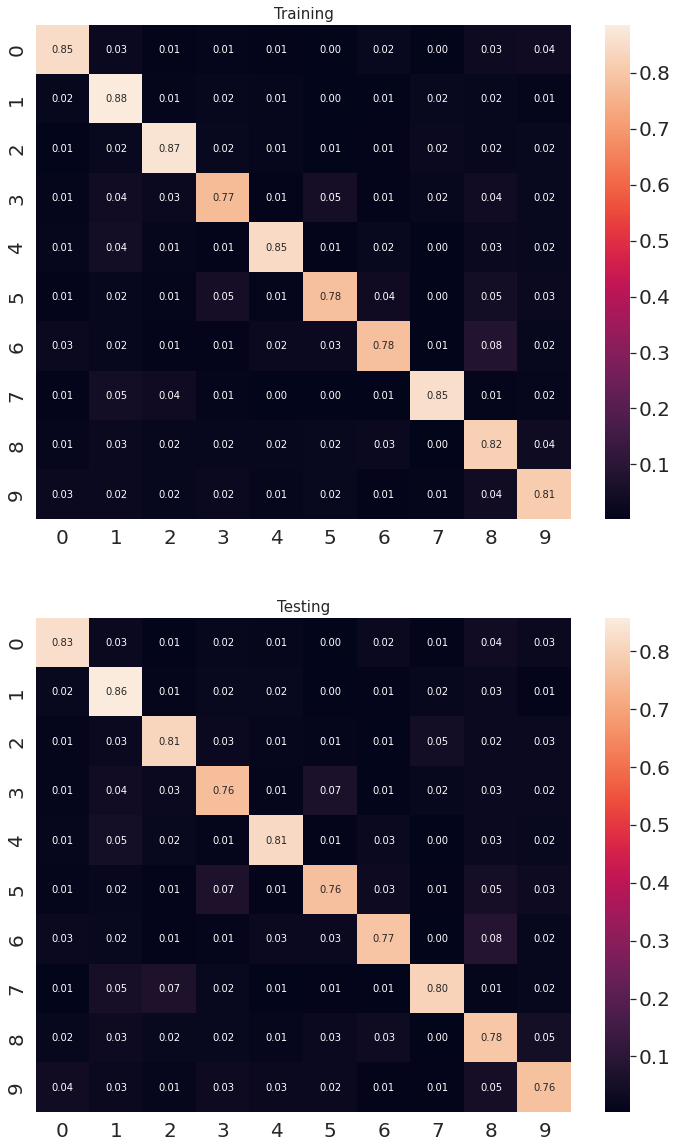

In [26]:
plot_confusion_matrix(
    y_train_class_m1, 
    y_test_class_m1, 
    train_preds_m1, 
    test_preds_m1, 
    CATEGORIES
)

### Observations
* Confussion matrix for training and test look similar. But for most of the cases the perrformance in test is poor compared to training

## Model Tunning

Let's now try to tune the original model.
We will use GridSearchCV tofind the optimal values for the following 
1. learning rate
2. batch size
3. epochs



In [27]:
#create copies to preserve original data
X_train_m2 = X_train.copy()
X_test_m2 = X_test.copy()
y_train_m2 = y_train.copy()
y_test_m2 = y_test.copy()

In [28]:
reset_seed()

# create model
def create_model(lr, batch_size, ):
    model2 = Sequential()  
    # Multiple Dense units with Relu activation
    model2.add(Dense(256, activation='relu', input_dim=1024)) 
    # model2.add(Dense(128, activation='relu'))
    model2.add(Dense(64, activation='relu'))
    model2.add(Dense(64, activation='relu'))
    model2.add(Dense(32, activation='relu'))
    model2.add(BatchNormalization())
    # Adding the output layer 
    # with 'softmax' activation for multiclass classification
    model2.add(Dense(num_classes, activation='softmax'))

    # Compile model
    model2.compile(
        loss=categorical_crossentropy, 
        optimizer=Adam(lr=lr), 
        metrics=['accuracy']
    )
    return model2

In [29]:
keras_estimator = KerasClassifier(build_fn=create_model, verbose=1)

In [30]:
# define the grid search parameters
param_grid = {
    'batch_size':[200, 300],
    "lr":[0.01, 0.001, 0.1],
    # "epochs": [50, 100],
}

kfold_splits = 3
grid = GridSearchCV(
    estimator=keras_estimator,
    verbose=1,
    cv=kfold_splits,
    param_grid=param_grid,
    n_jobs=-1
)

In [39]:
# Fitting the model
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',  
    verbose=1, 
    patience=20, 
    min_delta=0.001
)


In [32]:
grid_result = grid.fit( 
    X_train_m2, 
    y_train_m2, 
    validation_data=(X_test_m2, y_test_m2),
    callbacks=[es],
    epochs=250
) 

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Epoch 1/250
210/210 [==============================] - 2s 5ms/step - loss: 2.2860 - accuracy: 0.1419 - val_loss: 3.0902 - val_accuracy: 0.1007
Epoch 2/250
210/210 [==============================] - 1s 4ms/step - loss: 1.9865 - accuracy: 0.2772 - val_loss: 1.9736 - val_accuracy: 0.3135
Epoch 3/250
210/210 [==============================] - 1s 4ms/step - loss: 1.5157 - accuracy: 0.4915 - val_loss: 1.4324 - val_accuracy: 0.5383
Epoch 4/250
210/210 [==============================] - 1s 4ms/step - loss: 1.2748 - accuracy: 0.5900 - val_loss: 1.3795 - val_accuracy: 0.5417
Epoch 5/250
210/210 [==============================] - 1s 4ms/step - loss: 1.1607 - accuracy: 0.6323 - val_loss: 1.2651 - val_accuracy: 0.5803
Epoch 6/250
210/210 [==============================] - 1s 4ms/step - loss: 1.0828 - accuracy: 0.6562 - val_loss: 1.1426 - val_accuracy: 0.6321
Epoch 7/250
210/210 [==============================] - 1s 4ms/step - loss: 1.0211 

In [62]:
# Summarize results
print(f"Best Score: {grid_result.best_score_:.2f}")
print(f"Best params: {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best Score: 0.79
Best params: {'batch_size': 200, 'lr': 0.001}


We have identified the best params for the model.

Let's now build the final model using these params.

In [36]:
final_model = create_model(**grid_result.best_params_)
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               262400    
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 10)                330       
                                                      

In [38]:
# Fit the model
history_finaal = final_model.fit(
    X_train_m2, 
    y_train_m2, 
    validation_data=(X_test_m2, y_test_m2), 
    epochs=200, 
    batch_size=200,
    callbacks=[es]
)

Epoch 1/200
210/210 [==============================] - 1s 4ms/step - loss: 0.7198 - accuracy: 0.7757 - val_loss: 0.8041 - val_accuracy: 0.7547
Epoch 2/200
210/210 [==============================] - 1s 4ms/step - loss: 0.7038 - accuracy: 0.7783 - val_loss: 0.7837 - val_accuracy: 0.7573
Epoch 3/200
210/210 [==============================] - 1s 4ms/step - loss: 0.6919 - accuracy: 0.7820 - val_loss: 0.7842 - val_accuracy: 0.7612
Epoch 4/200
210/210 [==============================] - 1s 4ms/step - loss: 0.6794 - accuracy: 0.7866 - val_loss: 0.7904 - val_accuracy: 0.7556
Epoch 5/200
210/210 [==============================] - 1s 4ms/step - loss: 0.6739 - accuracy: 0.7874 - val_loss: 0.7745 - val_accuracy: 0.7623
Epoch 6/200
210/210 [==============================] - 1s 4ms/step - loss: 0.6633 - accuracy: 0.7918 - val_loss: 0.8166 - val_accuracy: 0.7482
Epoch 7/200
210/210 [==============================] - 1s 4ms/step - loss: 0.6577 - accuracy: 0.7930 - val_loss: 0.7945 - val_accuracy: 0.7548

#### Tuned Model Evaluation

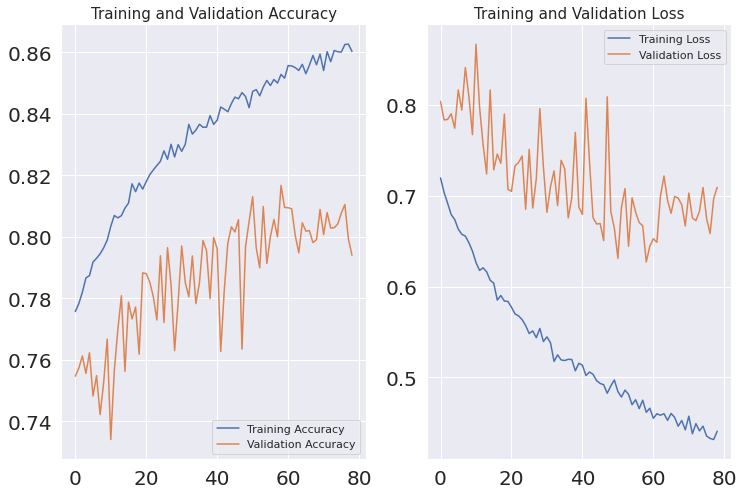

In [40]:
visualize_model_acc_loss_curves(history_finaal)

In [41]:
y_train_class_m2 = np.argmax(y_train_m2, axis=1)
y_test_class_m2 = np.argmax(y_test_m2, axis=1)

In [42]:
train_preds_m2 = model.predict(X_train_m2)
train_preds_m2 = np.argmax(train_preds_m2, axis=1)

test_preds_m2 = model.predict(X_test_m2)
test_preds_m2 = np.argmax(test_preds_m2, axis=1)

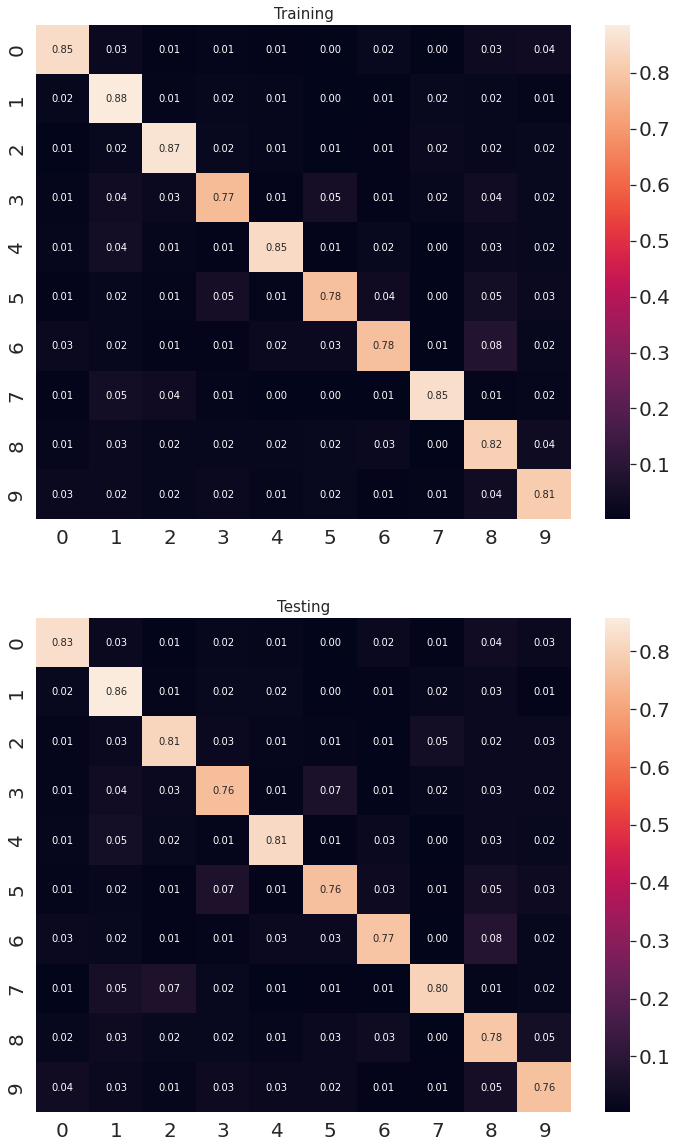

In [43]:
plot_confusion_matrix(
    y_train_class_m2, 
    y_test_class_m2, 
    train_preds_m2, 
    test_preds_m2, 
    CATEGORIES
)

In [89]:
# Final evaluation of the model
scores = final_model.evaluate(X_test_m2, y_test_m2, verbose=0)
print(f"Error rate in final model: {(100-scores[1]*100):.2f}%")
print(f"Accuracy of final model: {scores[1]*100:.2f}%")

Error rate in final model: 20.60%
Accuracy of final model: 79.40%


### Let's take a look at some of the misclassified images 

In [66]:
index = 0
misclassified_images = []
for label, predict in zip(y_test_class_m2, test_preds_m2):
    if label != predict: 
        misclassified_images.append(index)
    index +=1
# print(misclassified_images)
print(f"No of misclassified images: {len(misclassified_images)}")

No of misclassified images: 3716


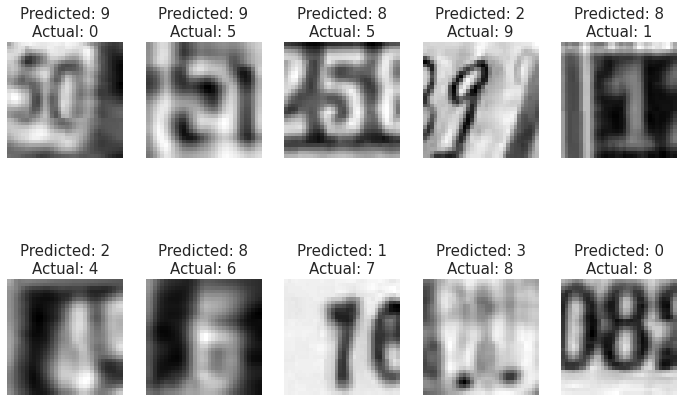

In [88]:
misc_ind = random.sample(misclassified_images, 10)
fig = plt.figure(figsize=(12, 8))
pos = 0
# Open the file 
h5f = h5py.File('/content/drive/My Drive/AIML/SVHN_single_grey1.h5', 'r')
test_imgs = h5f['X_test'][:]
h5f.close()
for i in misc_ind:
    ax = fig.add_subplot(2, 5, pos+1)
    plt.imshow(test_imgs[i], cmap="gray")
    title = f"Predicted: {test_preds_m2[i]}\nActual: {y_test_class_m2[i]}"
    plt.title(title)
    plt.axis('off')
    pos += 1
plt.show()

#### Observations:
* Tuned model has slightly improved accuracy compared to the base model
* Tuned model stopped at 79 of the alloted 200 epochs using early stopping

## Conclusion
* We built a Sequential model to predit the number from the image
* we then tuned the model to improve the performance
* We used GridsearchCV to find the optimum learning rate and batch size
* We also increased the number of epoch and used early_stopping to get optimum number of epochs
* final model has an accuracy of 79.40% on the test-dataset
* Final model is generalized as the accuracy on train and test data is not verying much